In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import os

from matplotlib import pyplot as plt

In [2]:
# Define the URL for the zip file and the local filename to use
url = 'http://ergast.com/downloads/f1db_csv.zip'
filename = 'f1db_csv.zip'

# Create a data directory if it doesn't exist
if not os.path.exists('../data'):
    os.makedirs('../data')

# Download the zip file
response = requests.get(url)

# Unzip the file into the data directory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall('../data')

dataframes = {}

# Loop through the csv files in the data directory
for csv_file in os.listdir('../data'):
    if csv_file.endswith('.csv'):
        # Read the csv file into a dataframe 
        df_name = csv_file.replace('.csv', '')
        dataframes[df_name] = pd.read_csv(f'../data/{csv_file}')

In [3]:
# races
races = dataframes['races']
print(races.shape)
races.head()

(1102, 18)


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [4]:
# drivers
drivers = dataframes['drivers']
print(drivers.shape)
drivers.head()

(857, 9)


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [5]:
# lap times
lap_times = dataframes['lap_times']
print(lap_times.shape)
lap_times.head()

(539176, 6)


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


In [6]:
fuller_df = lap_times.merge(races[['raceId', 'year', 'name']], on='raceId')
fuller_df = fuller_df.merge(drivers[['driverId', 'driverRef']], on='driverId')

In [7]:
mask_year = fuller_df['year'] >= 2000
data_years_after_2000 = fuller_df[mask_year]

In [8]:
avg_laptimes_by_race_and_driver = data_years_after_2000.groupby(['raceId', 'driverRef'], as_index=False).agg({'milliseconds': 'mean', 'driverRef': 'first', 'year': 'first', 'name': 'first', 'lap': 'last'})

In [9]:
total_laps_by_race = avg_laptimes_by_race_and_driver.groupby(['year', 'name'], as_index=False).agg({'raceId': 'first', 'year': 'first', 'name': 'first', 'lap': 'max'})

In [10]:
#mask_rem_retired = avg_laptimes_by_race_and_driver['lap'] == total_laps_by_race.loc[total_laps_by_race['raceId'] == avg_laptimes_by_race_and_driver['raceId']]['lap']

# Ensure only drivers who finished all laps are included.
mask_rem_retired = []
for index, row in avg_laptimes_by_race_and_driver.iterrows():
    raceID = row['raceId']
    total_laps = int(total_laps_by_race.loc[total_laps_by_race['raceId'] == raceID]['lap'])
    if row['lap'] < total_laps:
        mask_rem_retired.append(False)
    else:
        mask_rem_retired.append(True)


    

In [11]:
avg_laptimes_by_race_and_driver_finished_all_laps = avg_laptimes_by_race_and_driver[mask_rem_retired]

In [16]:
#top_3_fastest_drivers_by_race = avg_laptimes_by_race_and_driver_finished_all_laps.groupby(['year', 'name'], as_index=False).sort_values(by=['milliseconds'], ascending=False).head(3)

top_3_fastest_drivers_by_race = avg_laptimes_by_race_and_driver_finished_all_laps.groupby(['year', 'name'], as_index=False).apply(lambda x: x.sort_values(by = 'milliseconds', ascending = True).head(3).reset_index(drop = True))

raceId
1       AxesSubplot(0.125,0.11;0.775x0.77)
2       AxesSubplot(0.125,0.11;0.775x0.77)
3       AxesSubplot(0.125,0.11;0.775x0.77)
4       AxesSubplot(0.125,0.11;0.775x0.77)
5       AxesSubplot(0.125,0.11;0.775x0.77)
                       ...                
1093    AxesSubplot(0.125,0.11;0.775x0.77)
1094    AxesSubplot(0.125,0.11;0.775x0.77)
1095    AxesSubplot(0.125,0.11;0.775x0.77)
1096    AxesSubplot(0.125,0.11;0.775x0.77)
1098    AxesSubplot(0.125,0.11;0.775x0.77)
Name: milliseconds, Length: 434, dtype: object

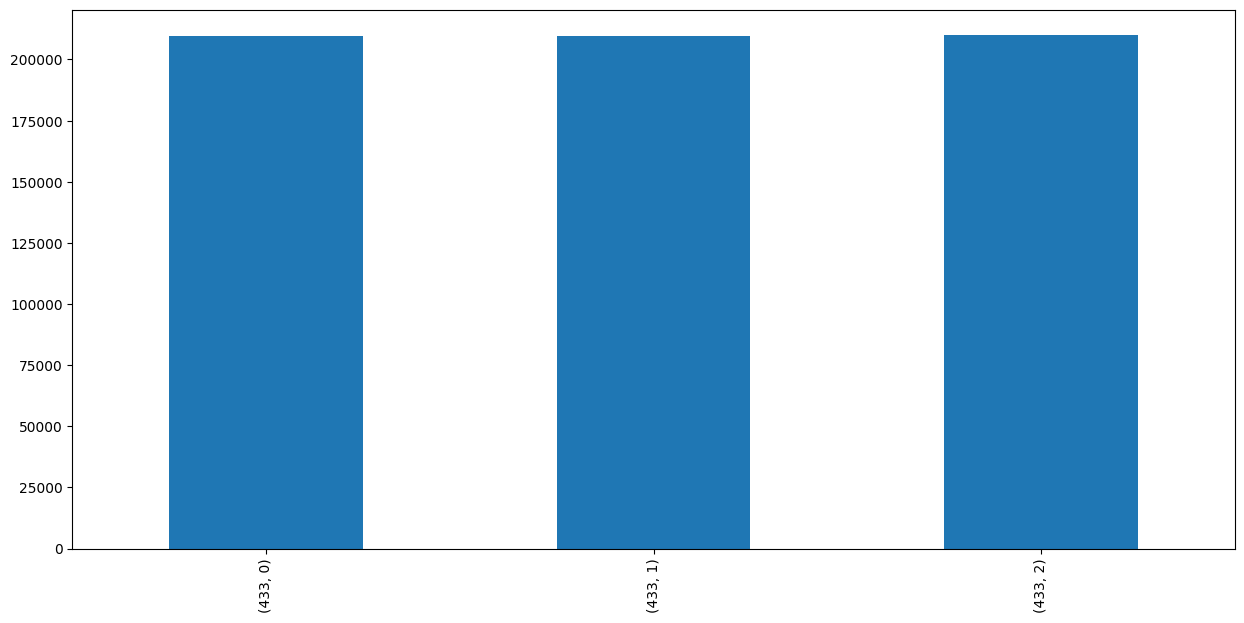

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
top_3_fastest_drivers_by_race.groupby(['raceId'])['milliseconds'].plot.bar(ax=ax)